# How to build a multi-agent network

!!! info "Prerequisites"
    This guide assumes familiarity with the following:

    - [Node](../../concepts/low_level/#nodes)
    - [Command](../../concepts/low_level/#command)
    - [Multi-agent systems](../../concepts/multi_agent)


In this how-to guide we will demonstrate how to implement a [multi-agent network](../../concepts/multi_agent#network) architecture.

Each agent can be represented as a node in the graph that executes agent step(s) and decides what to do next - finish execution or route to another agent (including routing to itself, e.g. running in a loop). A common pattern for routing in multi-agent architectures is handoffs. Handoffs allow you to specify:

1. which agent to navigate to next and (e.g. name of the node to go to)
2. what information to pass to that agent (e.g. state update)

To implement handoffs, agent nodes can return `Command` object that allows you to [combine both control flow and state updates](../command):

```python
def agent(state) -> Command[Literal["agent", "another_agent"]]:
    # the condition for routing/halting can be anything, e.g. LLM tool call / structured output, etc.
    goto = get_next_agent(...)  # 'agent' / 'another_agent'
    if goto:
        return Command(goto=goto, update={"my_state_key": "my_state_value"})
    
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Travel Recommendations Example

In this example we will build a team of travel assistant agents that can communicate with each other via handoffs.

We will create 3 agents:

* `travel_advisor`: can help with general travel destination recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.
* `sightseeing_advisor`: can help with sightseeing recommendations. Can ask `travel_advisor` and `hotel_advisor` for help.
* `hotel_advisor`: can help with hotel recommendations. Can ask `sightseeing_advisor` and `hotel_advisor` for help.

This is a fully-connected network - every agent can talk to any other agent. 

To implement the handoffs between the agents we'll be using LLMs with structured output. Each agent's LLM will return an output with both its text response (`response`) as well as which agent to route to next (`goto`). If the agent has enough information to respond to the user, `goto` will contain `finish`.

Now, let's define our agent nodes and graph!

In [3]:
from typing_extensions import TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command

model = ChatOpenAI(model="gpt-4o")


# Define a helper for each of the agent nodes to call
def call_llm(messages: list[AnyMessage], target_agent_nodes: list[str]):
    """Call LLM with structured output to get a natural language response as well as a target agent (node) to go to next.

    Args:
        messages: list of messages to pass to the LLM
        target_agents: list of the node names of the target agents to navigate to
    """
    # define JSON schema for the structured output:
    # - model's text response (`response`)
    # - name of the node to go to next (or 'finish')
    # see more on structured output here https://python.langchain.com/docs/concepts/structured_outputs
    json_schema = {
        "name": "Response",
        "parameters": {
            "type": "object",
            "properties": {
                "response": {
                    "type": "string",
                    "description": "A human readable response to the original question. Does not need to be a final response. Will be streamed back to the user.",
                },
                "goto": {
                    "enum": [*target_agent_nodes, "__end__"],
                    "type": "string",
                    "description": "The next agent to call, or __end__ if the user's query has been resolved. Must be one of the specified values.",
                },
            },
            "required": ["response", "goto"],
        },
    }
    response = model.with_structured_output(json_schema).invoke(messages)
    return response


def travel_advisor(
    state: MessagesState,
) -> Command[Literal["sightseeing_advisor", "hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["sightseeing_advisor", "hotel_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {"role": "ai", "content": response["response"], "name": "travel_advisor"}
    # handoff to another agent or halt
    return Command(goto=response["goto"], update={"messages": ai_msg})


def sightseeing_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a travel expert that can provide specific sightseeing recommendations for a given destination. "
        "If you need general travel help, go to 'travel_advisor' for help. "
        "If you need hotel recommendations, go to 'hotel_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["travel_advisor", "hotel_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {
        "role": "ai",
        "content": response["response"],
        "name": "sightseeing_advisor",
    }
    # handoff to another agent or halt
    return Command(goto=response["goto"], update={"messages": ai_msg})


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "sightseeing_advisor", "__end__"]]:
    system_prompt = (
        "You are a travel expert that can provide hotel recommendations for a given destination. "
        "If you need general travel help, ask 'travel_advisor' for help. "
        "If you need specific sightseeing recommendations, ask 'sightseeing_advisor' for help. "
        "If you have enough information to respond to the user, return 'finish'. "
        "Never mention other agents by name."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    target_agent_nodes = ["travel_advisor", "sightseeing_advisor"]
    response = call_llm(messages, target_agent_nodes)
    ai_msg = {"role": "ai", "content": response["response"], "name": "hotel_advisor"}
    # handoff to another agent or halt
    return Command(goto=response["goto"], update={"messages": ai_msg})


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("sightseeing_advisor", sightseeing_advisor)
builder.add_node("hotel_advisor", hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()

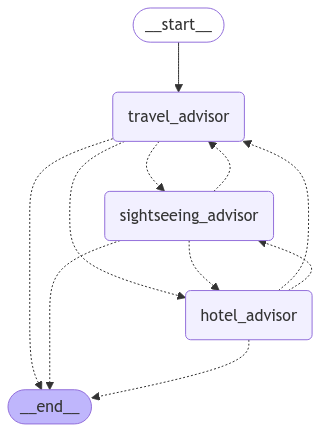

In [4]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

First, let's invoke it with a generic input:

In [5]:
for chunk in graph.stream(
    {"messages": [("user", "i wanna go somewhere warm in the caribbean")]}
):
    print(chunk)
    print("\n")

{'travel_advisor': {'messages': {'role': 'ai', 'content': 'The Caribbean offers many warm and beautiful destinations. Some popular ones include:\n\n1. **Jamaica** - Known for its beautiful beaches, reggae music, and vibrant culture.\n2. **Bahamas** - Offers stunning beaches and clear turquoise waters, perfect for relaxation and water activities.\n3. **Barbados** - Known for its friendly locals, delicious cuisine, and beautiful beaches.\n4. **Dominican Republic** - Offers a mix of beaches, mountains, and historical sites.\n5. **Aruba** - Known for its dry climate, beautiful beaches, and outdoor activities.\n\nWould you like recommendations for sightseeing or hotels in any of these destinations?', 'name': 'travel_advisor'}}}




You can see that in this case only the first agent (`travel_advisor`) ran. Let's now ask for more recommendations:

In [6]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination, give me some things to do and hotel recommendations",
            )
        ]
    }
):
    print(chunk)
    print("\n")

{'travel_advisor': {'messages': {'role': 'ai', 'content': 'I recommend visiting Jamaica, a vibrant and warm destination in the Caribbean known for its beautiful beaches, rich culture, and exciting activities.', 'name': 'travel_advisor'}}}


{'sightseeing_advisor': {'messages': {'role': 'ai', 'content': "For a warm and vibrant Caribbean destination, I recommend Jamaica. It's renowned for its stunning beaches, lively culture, and exciting activities.\n\n### Things to Do in Jamaica:\n1. **Explore Dunn’s River Falls**: A famous waterfall near Ocho Rios where you can climb the terraced steps and enjoy the natural pools.\n2. **Visit Bob Marley Museum**: Located in Kingston, this museum offers a deep dive into the life of the reggae legend.\n3. **Relax at Seven Mile Beach**: Known for its beautiful white sand and clear blue waters, it’s perfect for sunbathing and swimming.\n4. **Experience Negril Cliffs**: Enjoy breathtaking views and adventurous cliff diving.\n5. **Discover Blue Hole**: A hi

Voila - `travel_advisor` makes a decision to first get some sightseeing recommendations from `sightseeing_advisor`, and then `sightseeing_advisor` in turn calls `hotel_advisor` for more info. Notice that we never explicitly defined the order in which the agents should be executed!

## Game NPCs Example

In this example we will create a team of [non-player characters (NPCs)](https://en.wikipedia.org/wiki/Non-player_character) that all run at the same time and share game state (resources). At each step, each NPC will inspect the state and decide whether to halt or continue acting at the next step. If it continues, it will update the shared game state (produce or consume resources).

We will create 4 NPC agents:

- `villager`: produces wood and food until there is enough, then halts
- `guard`: protects gold and consumes food. When there is not enough food, leaves duty and halts
- `merchant`: trades wood for gold. When there is not enough wood, halts
- `thief`: checks if the guard is on duty and steals all of the gold when the guard leaves, then halts

Our NPC agents will be simple node functions (`villager`, `guard`, etc.). At each step of the graph execution, the agent function will inspect the resource values in the state and decide whether it should halt or continue. If it decides to continue, it will update the resource values in the state and loop back to itself to run at the next step.

Now, let's define our agent nodes and graph!

In [7]:
from typing_extensions import Annotated, TypedDict, Literal

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

import operator


class GameState(TypedDict):
    # note that we're defining a reducer (operator.add) here.
    # This will allow all agents to write their updates for resources concurrently.
    wood: Annotated[int, operator.add]
    food: Annotated[int, operator.add]
    gold: Annotated[int, operator.add]
    guard_on_duty: bool


def villager(state: GameState) -> Command[Literal["villager", "__end__"]]:
    """Villager NPC that gathers wood and food."""
    current_resources = state["wood"] + state["food"]
    if current_resources < 15:  # Continue gathering until we have enough resources
        print("Villager gathering resources.")
        # Loop back to the 'villager' agent
        return Command(goto="villager", update={"wood": 3, "food": 1})
    # NOTE: Returning Command(goto=END) is not necessary for the graph to run correctly
    # but it's useful for visualization, to show that the agent actually halts
    else:
        return Command(goto=END)


def guard(state: GameState) -> Command[Literal["guard", "__end__"]]:
    """Guard NPC that protects gold and consumes food."""
    if not state["guard_on_duty"]:
        return Command(goto=END)

    if state["food"] > 0:  # Guard needs food to keep patrolling
        print("Guard patrolling.")
        # Loop back to the 'guard' agent
        return Command(
            goto="guard",
            update={"food": -1},  # Consume food while patrolling
        )
    else:
        print("Guard leaving to get food.")
        return Command(goto=END, update={"guard_on_duty": False})  # Leave to get food


def merchant(state: GameState) -> Command[Literal["merchant", "__end__"]]:
    """Merchant NPC that trades wood for gold."""
    if state["wood"] >= 5:  # Trade wood for gold when available
        print("Merchant trading wood for gold.")
        return Command(goto="merchant", update={"wood": -5, "gold": 1})
    else:
        return Command(goto=END)


def thief(state: GameState) -> Command[Literal["thief", "__end__"]]:
    """Thief NPC that steals gold if the guard leaves to get food."""
    if not state["guard_on_duty"]:
        print("Thief stealing gold.")
        return Command(goto=END, update={"gold": -state["gold"]})
    else:
        # keep thief on standby (loop back to the 'thief' agent)
        return Command(goto="thief")


builder = StateGraph(GameState)

# Add NPC nodes
builder.add_node(villager)
builder.add_node(guard)
builder.add_node(merchant)
builder.add_node(thief)

# All NPCs start running in parallel
builder.add_edge(START, "villager")
builder.add_edge(START, "guard")
builder.add_edge(START, "merchant")
builder.add_edge(START, "thief")
graph = builder.compile()

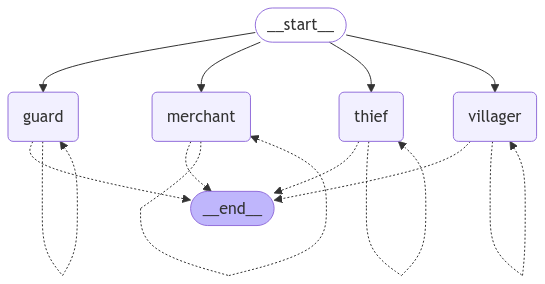

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run it with some initial state!

In [9]:
initial_state = {"wood": 10, "food": 3, "gold": 10, "guard_on_duty": True}
for state in graph.stream(initial_state, stream_mode="values"):
    print("Game state", state)
    print("\n")

Game state {'wood': 10, 'food': 3, 'gold': 10, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state {'wood': 8, 'food': 3, 'gold': 11, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state {'wood': 6, 'food': 3, 'gold': 12, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state {'wood': 4, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Game state {'wood': 7, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Game state {'wood': 10, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Game state {'wood': 13, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Game state {'wood': 13, 'food': 2, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Game sta